Import libraries and MNIST dataset

In [154]:
# Includes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Regroup data in low digits (0...5) and high (6..9)

In [155]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

# Reshape
data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Print
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


Load Frozen model (Features model) and features for the pre-trained data

In [179]:
features = np.loadtxt('Models/Original_model/ll_features_10.txt')
labels_features = np.loadtxt('Models/Original_model/ll_labels_features_10.txt')
labels_features = labels_features.astype(int)
model = keras.models.load_model('Models/Original_model/mnist_cnn.h5')

# Print
# model.summary()
# Features_model.summary()

Features_model = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
Features_model.compile()

# Kmeans 

## Fit initial dataset - Sklearn Kmeans

In [353]:
# Fit initial dataset. First we need to extract the corresponding images from the features list

# Define initial set of features
labels_init_list = list([1, 9, 5, 0])
# labels_init_list = list([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

# Initialize features and labels arrays for 
labels_init = []
features_init = []

for i in range(0, len(features)):
      if labels_features[i] in labels_init_list:
        features_init.append(features[i,:])
        labels_init.append(labels_features[i])

# debug
print(np.shape(features_init))
print(np.shape(features))

# Fit initial dataset using n clusters
n_clust_init = len(labels_init_list)

Kmeans = KMeans(n_clusters = n_clust_init)
Kmeans.fit(features_init)

# Kmean.cluster_centers_ -> Centroidi
# Kmeans.cluster_centers_.shape
# print("True labels",labels_init)
# print("Pseudo labels", Kmeans.labels_)

(40, 512)
(100, 512)


KMeans(n_clusters=4)

### Confusion Matrix

In [358]:
# 1: map labels to rows
# [1, 9, 5, 0]

fake_labels_init = np.empty(np.shape(labels_init))

for i in range(0,len(labels_init)):
    fake_labels_init[i] = labels_init_list.index(labels_init[i])

# print(fake_labels_init)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(fake_labels_init, Kmeans.labels_)

array([[ 0, 10,  0,  0],
       [ 0,  0,  9,  1],
       [ 0,  0,  1,  9],
       [10,  0,  0,  0]])

## Calcolo features dei nuovi dati
Uso il Features_model
e (data_train, label_train),(data_test, label_test)

1/1 [==============================] - 0s 30ms/step
[[6555.59657454 6557.99986744 6554.07962402 6546.09664211]]


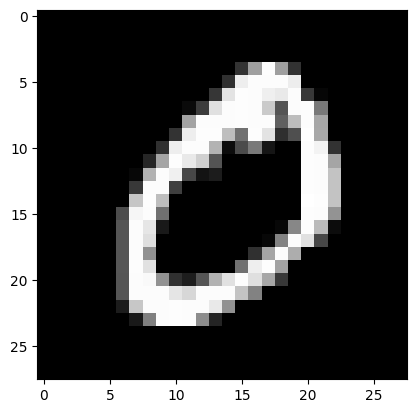

In [217]:
# Assegno i centroidi iniziali
centroids = {}
for i in range(n_clust_init):
    centroids[i] = Kmeans.cluster_centers_[i]




# Array that simulates the data stream from the OPENMV
data_stream = data_train


# Processing one image at a time

idx = 1 # Simulate image capture

img = data_stream[idx].reshape(1, 28, 28, 1) # Image must be reshaped
img_features = Features_model.predict(img)

# Calcolo distanza rispetto a tutti i cluster
dist = Kmeans.transform(img_features)

print(dist)


# plot the input
fig = plt.figure
img_plt = img.reshape(28, 28)
plt.imshow(img_plt, cmap='gray')
plt.show()







In [170]:

# Aggiorno i centroidi con i nuovi dati

# 1) prelevo la nuova immagine
# 2) Ne calcolo le features usando il frozen model
# 3) Capire a quale cluster l'immagine appartiene -> Predict
# 4) In base allo score
#       4.1) Aggiorno il centroide con il nuovo dato -> settare il learning rate 
#       4.2) Creo un nuovo cluster con l'immagine nuova.

# Da qui in poi bisogna capire come creare 



# Variables
max_iter = 300
tol = 0.01



# Sposto i centroidi per ottimizzarli
for ii in range(max_iter):

    # Inizializzo i classificatori
    classifications = {}
    for i in range(n_clust_init):
        classifications[i] = []

    for featureset in data:
        distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
        classification = distances.index(min(distances))        # retrieve index of cluster with smallest distance
        classifications[classification].append(featureset)

    prev_centroids = dict(centroids)


    for classification in classifications:
      centroids[classification] = np.average(classifications[classification], axis=0)

    optimized = True

    for c in centroids:
        original_centroid = prev_centroids[c]
        current_centroid = centroids[c]

        #print((current_centroid - original_centroid) / original_centroid)

        #if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > tol:
        #    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
    #        optimized = False

    if optimized:
        break

In [168]:
# Variables
max_iter = 300
tol = 0.01


data = features_init


# Sposto i centroidi per ottimizzarli
for ii in range(max_iter):

    # Inizializzo i classificatori
    classifications = {}
    for i in range(n_clust_init):
        classifications[i] = []

    for featureset in data:
        distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
        classification = distances.index(min(distances))        # retrieve index of cluster with smallest distance
        classifications[classification].append(featureset)

    prev_centroids = dict(centroids)


    for classification in classifications:
      centroids[classification] = np.average(classifications[classification], axis=0)

    optimized = True

    for c in centroids:
        original_centroid = prev_centroids[c]
        current_centroid = centroids[c]

        #print((current_centroid - original_centroid) / original_centroid)

        #if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > tol:
        #    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
    #        optimized = False

    if optimized:
        break


print(centroids[0].shape)

#print(centroids[0])

#print(centroids[3])

print(np.array(classifications[0]).shape)
print(np.array(classifications[1]).shape)
print(np.array(classifications[2]).shape)
print(np.array(classifications[3]).shape)







(512,)
(2, 512)
(26, 512)
(11, 512)
(1, 512)


In [61]:




# Fit






class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):

        # Initialize centroids with first data incoming

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def update(self, new_data, delta):
        for featureset in new_data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]

            if min(distances) < delta:
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            else:
                self.centroids[self.k] = featureset
                self.classifications[self.k] = []
                self.classifications[self.k].append(featureset)
                self.k = self.k + 1






IndentationError: expected an indented block after function definition on line 14 (3852728260.py, line 18)

50.0
513.8888888888889
19.333333333333336
85.97370695537461


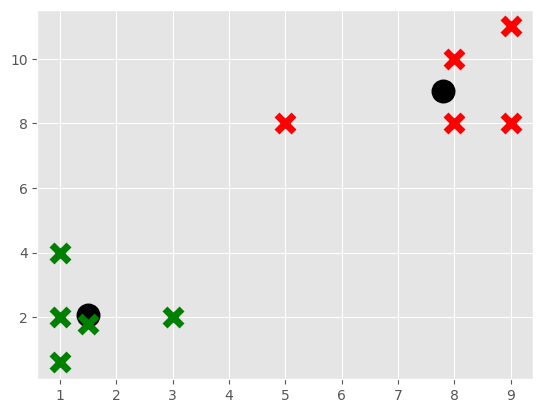

In [45]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
colors = 10 * ["g", "r", "c", "b", "k"]

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8],
              [8, 8],
              [8,10],
              [9,8],
              [3,2],
              [1,4],
              [1, 0.6],
              [9, 11]])

clf = K_Means(k = 2)
clf.fit(X)

X1 = np.array([[6, 8],
               [7, 10],
               [6, 4],
               [2, 2],
               [2, 3]])

#Updating the model with X1 and threshold of 4 
# clf.update(X1, 4)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)

plt.show()